In [1]:


import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import cvxpy as cp
import torch
import torch.nn as nn
import random
from itertools import chain
from sklearn.model_selection import train_test_split
from torchsummary import summary
import sys
import io
import copy
import time
import torch
from torch.utils import data as torch_data
import pickle
import itertools
import warnings
from numpy import linalg as LA
from sklearn import preprocessing
from cvxpylayers.torch.cvxpylayer import CvxpyLayer

In [2]:

training_data = []
#inci_matrix = torch.tensor([ [-1,-1,-1,0,0,0,0,0],
 #   [1,0,0,-1,0,-1,0,0],
  #             [0,1,0,1,1,0,-1,0],
               
   #            [0,0,1,0,-1,0,0,-1],
    #           [0,0,0,0,0,1,1,1] 
     #          ],dtype=torch.float32)


inci_matrix = pickle.load( open( "matrix_{}b{}.p".format(20,30), "rb" ) )



#print(inci_matrix)  
while len(training_data) != 4000:
    
    z = torch.tensor([float(random.uniform(0.001, 1)) for i in range(30)])
    #z = torch.tensor([e1,e2,e3, e4, e5, e6, e7, e8])
    training_data.append(z)
training_data = torch.stack(training_data)

#model_load = torch.load('shortest_path_proxy_{}.model'.format('Dag'))

In [3]:
def pred_net_data_generation(inputs):
    
    data = []
    target = []

    N,M  = inputs.shape
    
    A = torch.rand((M, M))
   
    print("Condition number: ",LA.cond(A))

    A_Inv = torch.linalg.inv(A)
    alpha = 0.05 # perturbation amplitude

    
    for i in inputs:
        target.append(i)
        x = torch.nn.functional.normalize(torch.matmul(A_Inv,i), dim=0, p=2)
        data.append(x)
        
    
    return data, target

In [4]:
#print(training_data)
x_nn, y_nn = pred_net_data_generation(training_data)

x_nn = torch.stack(x_nn)
y_nn = torch.stack(y_nn)

#x_nn = preprocessing.normalize(x_nn)
#y_nn = preprocessing.normalize(y_nn)
#print(x_nn[0])
print(x_nn.shape)

Condition number:  232.18324
torch.Size([4000, 30])


In [5]:
seed_random = 9999
np.random.seed(seed_random)
x_train, x_test, y_train, y_test = train_test_split(x_nn, y_nn, test_size=0.25, train_size=0.75, random_state=seed_random, shuffle=True)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, train_size=0.8, random_state=seed_random, shuffle=True)

x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)
x_cv = preprocessing.normalize(x_cv)
y_train = preprocessing.normalize(y_train)
y_test = preprocessing.normalize(y_test)
y_cv = preprocessing.normalize(y_cv)

print('shapes of train, validation, test data', x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)

shapes of train, validation, test data (2400, 30) (2400, 30) (600, 30) (600, 30) (1000, 30) (1000, 30)


In [6]:
import torch
from torch import nn
from torch.nn import init

# JK
def init_weights(net, init_type='normal', init_gain=0.02):
    """Initialize network weights.

    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.

    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """

    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming_uniform':
                #init.kaiming_uniform(m.weight.data, a=0, mode='fan_in')
                #init.kaiming_uniform(m.bias.data, a=0, mode='fan_in')
                nn.init.kaiming_uniform_(m.weight.data, mode='fan_in', nonlinearity='relu')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
                init.orthogonal_(m.bias.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find(
                'BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            init.normal_(m.weight.data, 1.0, init_gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)


In [7]:
params = {'iterations':1000,'batch_size': 128, 'input_size': 30, 'hidden_units_1': 100, 'hidden_units_2':100, 'hidden_units_3': 100, 'hidden_units_4': 100, 'hidden_units_5': 100, 'hidden_units_6': 100,'hidden_units_7': 100,'do_1': 0.2, 'do_2': 0.1, 'do_3': 0.05, 'output_size': 30, 'lr': 0.00001, 'min_lr': 1e-05, 'max_lr': 0.01, 'epochs': 20, 'lr_sched': 'clr', 'lr_sched_mode': 'triangular', 'gamma': 0.95}

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

trainset = torch_data.TensorDataset(torch.as_tensor(x_train, dtype=torch.float, device=device), 
torch.as_tensor(y_train, dtype=torch.float, device=device))
train_dl = torch_data.DataLoader(trainset, batch_size=params['batch_size'], drop_last=True)

val_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_cv, dtype=torch.float, device=device), 
torch.as_tensor(y_cv, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

test_dl = torch_data.DataLoader(torch_data.TensorDataset(torch.as_tensor(x_test, dtype=torch.float, device=device), 
torch.as_tensor(y_test, dtype=torch.float, device=device)), batch_size=params['batch_size'], drop_last=True)

device: cpu


In [9]:
torch.manual_seed(9999)
def get_model():
    """
    creates a PyTorch model. Change the 'params' dict above to 
    modify the neural net configuration.
    """
    model = torch.nn.Sequential(
       torch.nn.Linear(params['input_size'], params['hidden_units_1']),
       #torch.nn.ReLU(),
      # torch.nn.Linear(params['hidden_units_1'], params['hidden_units_2']),
       #torch.nn.ReLU(),
      torch.nn.BatchNorm1d(params['hidden_units_1']),
         torch.nn.Dropout(p=params['do_1']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_1'], params['hidden_units_2']),
        torch.nn.BatchNorm1d(params['hidden_units_2']),
         torch.nn.Dropout(p=params['do_2']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_2'], params['hidden_units_3']),
        torch.nn.BatchNorm1d(params['hidden_units_3']),
         torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_3'], params['hidden_units_4']),
        torch.nn.BatchNorm1d(params['hidden_units_4']),
        torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_4'], params['hidden_units_5']),
        torch.nn.BatchNorm1d(params['hidden_units_5']),
        torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_5'], params['hidden_units_6']),
        torch.nn.BatchNorm1d(params['hidden_units_6']),
        torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_6'], params['hidden_units_7']),
        torch.nn.BatchNorm1d(params['hidden_units_7']),
        torch.nn.Dropout(p=params['do_3']),
        torch.nn.ReLU(),
        torch.nn.Linear(params['hidden_units_7'], params['output_size']),
       #torch.nn.ReLU(),
        #torch.nn.Sigmoid()
    )
    return model

def regret(y_true, y_hat,proxy):
    
    A = inci_matrix
     
    eps_ = 0.2
    #print( "weight_target {} , predicted weight {}".format(y_true[0], y_hat[0]))
    
    y_true_decision = proxy(y_true)
    
    y_hat_decision = proxy(y_hat)
    
    #print( "weight_target decision {} , predicted weight decision {}".format(y_true_decision[0], y_hat_decision[0]))
    
    
    objective_true =( (y_true * y_true_decision).sum(1) 
                     #+ torch.tensor([eps_*torch.sum(torch.square(y_true_decision[i])) for i in range((y_true_decision.shape)[0])])
                     #+torch.tensor([eps_*torch.sum(y_true_decision[i]*torch.log(y_true_decision[i])) for i in range((y_true_decision.shape)[0])])
                     + torch.tensor([eps_*torch.norm(y_true_decision[i], p=2) for i in range((y_true_decision.shape)[0])]) 
                     )
    objective_hat =  ( (y_true * y_hat_decision).sum(1) 
                   #   + torch.tensor([eps_*torch.sum(torch.square(y_hat_decision[i])) for i in range((y_hat_decision.shape)[0])])
                     # +torch.tensor([eps_*torch.sum(y_hat_decision[i]*torch.log(y_hat_decision[i])) for i in range((y_hat_decision.shape)[0])])
                      + torch.tensor([eps_*torch.norm(y_hat_decision[i], p=2) for i in range((y_hat_decision.shape)[0])]) 
                      )
    
   
    regret = torch.mean(objective_hat - objective_true)
    #print(regret)
   
    loss_vec = (y_true * proxy(y_hat)).sum(1)
    
  
    loss = torch.mean(loss_vec)
   
    return loss, regret

def regret_cvxpy(y_true, y_hat,cvx):
    A = inci_matrix
    
    
    
    eps_ = 0.2
    
    
    y_true_decision = cvx(A,y_true)
    y_hat_decision = cvx(A,y_hat)
    
    #print(y_true_decision)
    
    #print(y_true_decision[0], y_hat_decision[0])
    
    
    objective_true =( (y_true * y_true_decision).sum(1) 
                   #  + torch.tensor([eps_*torch.sum(torch.square(y_true_decision[i])) for i in range((y_true_decision.shape)[0])])
                    #+torch.tensor([eps_*torch.sum(y_true_decision[i]*torch.log(y_true_decision[i])) for i in range((y_true_decision.shape)[0])])
                     + torch.tensor([eps_*torch.norm(y_true_decision[i], p=2) for i in range((y_true_decision.shape)[0])])
                     )
    #print(objective_true[0])
    
    objective_hat =  ( (y_true * y_hat_decision).sum(1) 
                    #  + torch.tensor([eps_*torch.sum(torch.square(y_hat_decision[i])) for i in range((y_hat_decision.shape)[0])])
                   # +torch.tensor([eps_*torch.sum(y_hat_decision[i]*torch.log(y_hat_decision[i])) for i in range((y_hat_decision.shape)[0])])
                     + torch.tensor([eps_*torch.norm(y_hat_decision[i], p=2) for i in range((y_hat_decision.shape)[0])])  
                      )
    
    regret = torch.mean(objective_hat - objective_true)
    return regret

model = get_model()

initialize_model = True
if initialize_model:
    init_weights(model, 'xavier')

print('model loaded into device=', next(model.parameters()).device)

# this is just to capture model summary as string
old_stdout = sys.stdout
sys.stdout = buffer = io.StringIO()

summary(model, input_size=(params['input_size'], ))

sys.stdout = old_stdout
model_summary = buffer.getvalue()
#print('model-summary\n', model_summary)
# later this 'model-summary' string can be written to tensorboard

lr_reduce_patience = 20
lr_reduce_factor = 0.1

loss_fn = regret_cvxpy#nn.MSELoss()  

optimizer = torch.optim.SGD(model.parameters(), lr=params['lr'])#, momentum=0.9, dampening=0, weight_decay=0, nesterov=True)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=params['lr'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

#if params['lr_sched'] == 'reduce_lr_plateau':
 #   lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=lr_reduce_factor, patience=lr_reduce_patience, verbose=True, threshold=0.00001, threshold_mode='rel', cooldown=0, min_lr=1e-9, eps=1e-08)
#elif params['lr_sched'] == 'clr':
 #   lr_sched = torch.optim.lr_scheduler.CyclicLR(optimizer, params['min_lr'], params['max_lr'], step_size_up=8*len(train_dl), step_size_down=None, mode=params['lr_sched_mode'], last_epoch=-1, gamma=params['gamma'])

#print('lr scheduler type:', lr_sched)
#for param_group in optimizer.param_groups:
 #   print(param_group['lr'])

initialize network with xavier
model loaded into device= cpu


In [10]:
def calc_violations(inc_matrix, selected_edges):
    #viol = 0
    viol_lst = []
    n,m = inc_matrix.shape
    b = np.zeros(n)
    # these are flipped to get 0 for violations, original are the opposite 
    b[0] = -1
    b[n-1] = 1
    
    batch_size, null = selected_edges.shape
    
    for i in selected_edges:
      #torch.unsqueeze(i,1)
      #print(i.shape)
      viol = 0
      
      a = torch.matmul(inci_matrix,i)
      #print(a.shape)
     # print(a.shape)
      #print(b.shape)
      c = a - b 
      for values in c:
        viol += torch.abs(values) 
      
      
      
      for j in i:
        if j < 0:
          viol += torch.abs(j)
        elif j > 1:
          viol += torch.abs(j-1)
      viol_lst.append(viol)
      
    #print(viol_lst)
      
    return  max(viol_lst), sum(viol_lst)/len(viol_lst)   

In [11]:
def cvx_py(A, pred):
   # print('here')
    warnings.filterwarnings('ignore')
    
    
    eps = 0.2
    
    batch_s, edges  = pred.shape
   
   # print(batch_s)
    
    n,m = A.shape
    target = torch.zeros((batch_s, edges))
    
    #print(target.shape)
    c = cp.Parameter(m)
    #c = c.detach().numpy()
    b = np.zeros(n)
    b[0] = -1
    b[n-1] = 1
    x = cp.Variable(shape=m)
    constr = [x>=0, x <= 1,
             A@x == b]
    
  
    #- eps*cp.sum(cp.entr(x))
    #+ eps*cp.norm(x,p=2)
    #eps*cp.sum(x**2)
    problem  = cp.Problem(cp.Minimize(c @ x + eps*cp.norm(x,p=2) ),constr)
    cvxlayer = CvxpyLayer(problem, parameters=[c], variables=[x])
  
   
    solutions = lambda z: cvxlayer(z)[0] #, args = {'tol':1e-10})[0]
    index = 0
    #print(len(pred))
    for x in pred:
        #print(x)
         
        #print(x)
       # print(x)
        
        sol = solutions(x)
        target[index] = sol
        #print(sol)                        
        
        #print(problem.value)
        index += 1
    
    return torch.Tensor(target)

In [12]:
patience = 130
best = 1000
fails = 0
flag = False                                           
infeasible_count = 0                                                               

l1_error_weight_pred = [] # this is to compare distro of predicted arc weights and actual arc weights
l2_error_weight_pred = []
          
avg_constraint_viol_perbatch = []
max_constraint_viol_perbatch = []

#avg_constraint_viol_cvxpy = []
#max_constraint_viol_cvxpy = []

train_loss = [] 
val_loss = []

train_regret = []
val_regret_lst = []

l1_error_decision_pred = []
l2_error_decision_pred = []


l1_loss_weight = nn.L1Loss()
l2_loss_weight = nn.MSELoss()
#l1_loss_decision = nn.L1Loss()

A = inci_matrix


#model_load = torch.load('shortest_path_proxy_{}.model'.format('Dag'))



train_iterator = itertools.cycle(train_dl)

val_iter = itertools.cycle(test_dl)


for iterations in range(0, params['iterations']):
  
  
  
  # loop over the dataset multiple times
  print("---------------------------------------iteration: {}".format(iterations))
  #running_loss = 0.0
  #running_viol = 0.0
  #stime = time.time()
  model.train()
  data = next(iter(train_iterator))
  inputs, targets  = data
  #out_1 = 
  linear_layer_output = torch.nn.functional.normalize(model(inputs))
  #print(linear_layer_output[0])
  with torch.no_grad():
    l1_weight_val = l1_loss_weight(linear_layer_output,targets)
    l2_weight_val = l2_loss_weight(linear_layer_output,targets)
    
    l1_error_weight_pred.append(l1_weight_val.item())
    l2_error_weight_pred.append(l2_weight_val.item())
        
  #l1_error_decision_pred.append(l1_decision_val)
  #

  #print("l1 decision: {}".format(l1_decision_val.item()))
  print("l1 weight: {}".format(l1_weight_val.item()))
                  
  regret = loss_fn(targets, linear_layer_output, cvx_py)
  regret.backward()
  optimizer.step()
  optimizer.zero_grad()
  
  #print("regret", regret.item())
  
  train_regret.append(regret.item())
  




  model.eval()
  val_data = next(iter(val_iter))
  
  val_inputs, val_targets = val_data
  with torch.no_grad():
   # print("eval----------")
    linear_layer_output_val = torch.nn.functional.normalize(model(val_inputs))
    val_regret = loss_fn(val_targets, linear_layer_output_val, cvx_py)
    val_regret_lst.append(val_regret.item())
    #print("eval done------")

  print('train regret : {}, valid regret : {} '.format(regret, val_regret))
  
  if val_regret < best - 1e-4:
    if val_regret > 0:
      print("\n UPDATE \n")
      best_model = copy.deepcopy(model)
      fails = 0
      best = val_regret
  else:
    fails = fails + 1
  if fails > patience:
    print("Early Stopping. Valid hasn't improved for {}".format(patience))
    flag = True
  if flag:
    break
  val_regret = 0


    

print('Finished Training')
print("number of infeasible solutions: ",infeasible_count)

---------------------------------------iteration: 0
l1 weight: 0.23467223346233368


train regret : 0.7384096384048462, valid regret : 0.02788209728896618 

 UPDATE 

---------------------------------------iteration: 1
l1 weight: 0.2331901341676712
train regret : 0.6628027558326721, valid regret : 0.03337489441037178 
---------------------------------------iteration: 2
l1 weight: 0.23137953877449036
train regret : 0.580787718296051, valid regret : 0.027828317135572433 
---------------------------------------iteration: 3
l1 weight: 0.23047995567321777
train regret : 0.5062431693077087, valid regret : 0.04360264912247658 
---------------------------------------iteration: 4
l1 weight: 0.2261754721403122
train regret : 0.43496081233024597, valid regret : 0.03862551227211952 
---------------------------------------iteration: 5
l1 weight: 0.2281874716281891


KeyboardInterrupt: 

In [ ]:
def cvx_py_test(A, pred):
   
    warnings.filterwarnings('ignore')
    
    
    #eps = 0.7
    
    batch_s, edges  = pred.shape
   
    
    n,m = A.shape
    target = torch.zeros((batch_s, edges))
    
    #print(target.shape)
    c = cp.Parameter(m)
    #c = c.detach().numpy()
    b = np.zeros(n)
    b[0] = -1
    b[n-1] = 1
    x = cp.Variable(shape=m)
    constr = [x>=0, x <= 1,
             A*x == b]
    
  
    #- eps*cp.sum(cp.entr(x))
    #+ eps*cp.norm(x,p=2)
    #eps*cp.sum(x**2)
    problem  = cp.Problem(cp.Minimize(c @ x ),constr)
    cvxlayer = CvxpyLayer(problem, parameters=[c], variables=[x])
  
   
    solutions = lambda z: cvxlayer(z)[0] #, args = {'tol':1e-10})[0]
    index = 0
    for x in pred:
        
         
        #print(x)
       # print(x)
        
            #sol = solutions(x)
        target[index] = solutions(x)                            
        
        #print(problem.value)
        index += 1
    
    return torch.Tensor(target)

In [ ]:
test_iter = itertools.cycle(test_dl)
test_l2 = nn.MSELoss() 
test_l1 = nn.L1Loss() 


l2_weights = []
l2_decision = []
test_viol = []
l1_weights = []
inf_time = []

#optimal_path_acc = []

i =0 
for inputs, targets in test_iter:
    
    start = time.process_time()
    linear_layer_output = torch.nn.functional.normalize(model(inputs))
    selected_edges = cvx_py_test(inci_matrix,linear_layer_output)
    inf_time.append(time.process_time() - start)
    
    error_w = test_l2(linear_layer_output,targets)
    l2_weights.append(error_w)
    
    error_w1 = test_l1(linear_layer_output,targets)
    l1_weights.append(error_w1)

    selected_edges_targets = cvx_py_test(inci_matrix,targets)
    error_d = test_l2(selected_edges,selected_edges_targets)
    l2_decision.append(error_d)
    
    vio = calc_violations(inci_matrix,selected_edges.detach())[1]
    test_viol.append(vio)
    #selected_edges = model_load(linear_layer_output)
    #selected_edges_targets = cvx_py(A,linear_layer_output) 
    i += 1
    if i == 5:
        break

print("l2 weights", sum(l2_weights)/len(l2_weights))
print("l2 decision", sum(l2_decision)/len(l2_decision))
print("inf time", sum(inf_time)/len(inf_time))
print("violations", sum(test_viol)/len(test_viol))
print("l1 weights", sum(l1_weights)/len(l1_weights))
    

l2 weights tensor(0.0145, grad_fn=<DivBackward0>)
l2 decision tensor(0.0028, grad_fn=<DivBackward0>)
inf time 0.503125
violations tensor(0.0004, dtype=torch.float64)
l1 weights tensor(0.0974, grad_fn=<DivBackward0>)


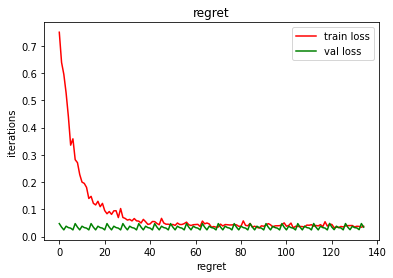

In [ ]:
plt.plot(train_regret,color='r', label='train loss')
plt.plot(val_regret_lst, color='g', label='val loss')

plt.xlabel("regret")
plt.ylabel("iterations")
plt.title("regret")

plt.legend()

plt.show()

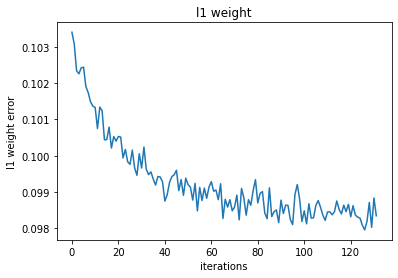

In [ ]:
#for i in range(len(l1_error_weight_pred)):
 #   l1_error_weight_pred[i] = l1_error_weight_pred[i].cpu().detach().numpy()

plt.plot(l1_error_weight_pred)
plt.ylabel('l1 weight error')
plt.xlabel('iterations')
plt.title("l1 weight")
plt.show()

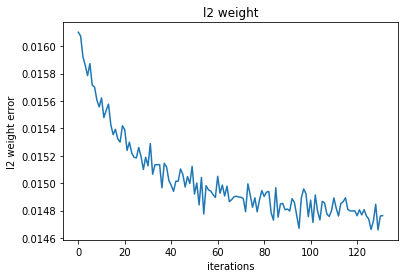

In [ ]:
#for i in range(len(l1_error_weight_pred)):
 #   l1_error_weight_pred[i] = l1_error_weight_pred[i].cpu().detach().numpy()

plt.plot(l2_error_weight_pred)
plt.ylabel('l2 weight error')
plt.xlabel('iterations')
plt.title("l2 weight")
plt.show()